##1. 생성기와 판별자 가져오기를 지원하는 패키지 설치

In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

##2. 입력파이프라인
랜덤하게 이미지 수정(위치, 반전 등)  
무작위 지터링 - 이미지 286x286크기로 조정후 256x256으로 무작위로 자름  
무작위 미러링 - 이미지 좌우로 무작위로 뒤집힘

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteM5OCX5/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteM5OCX5/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteM5OCX5/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteM5OCX5/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HIGHT = 256

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size = [IMG_HIGHT, IMG_WIDTH, 3]
  )

  return cropped_image
#random하게 이미지 자르기,tf.image의 random_crop()이용, size는 위에서 결정한 IMG_HIGHT, IMG_WIDTH이용

In [7]:
#images들을 [-1, 1]로 정규화
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image

#image를 image/127.5로 나누고(아마도 기존 이미지의 사이즈) 1을 빼준다

In [8]:
#이미지를 286x286x3으로 만들고 256x256x3으로 자른 후 랜덤하게 좌우반전
def random_jitter(image):
  #resizing to 286x286x3
  image = tf.image.resize(image, [286,286],method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  #이미지의 크기를 286x286으로 바꾸고 그 방식을 method 뒤의 방법 이용...

  #randomly cropping to 256x256x3
  image = random_crop(image)
  #아까 만든 함수 이용, random하게 이미지를 위에서 정한 IMG_HIGHT, IMG_WIDTH로 바꾼다

  #random mirroring
  image = tf.image.random_flip_left_right(image)
  #이미지를 랜덤하게 좌우반전

  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)#이미지 랜덤하게 수정
  image = normalize(image)#이미지 정규화
  return image
#train데이터는 랜덤하게 수정 및 정규화

In [10]:
def preprocess_image_test(image, label):
  image=normalize(image)#이미지 정규화
  return image
#test데이터는 이미지 정규화

In [11]:
train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_horses = test_horses.map(preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [12]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

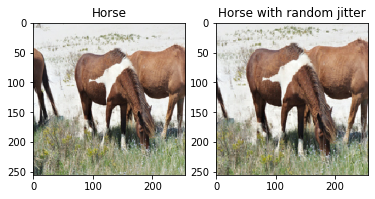

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

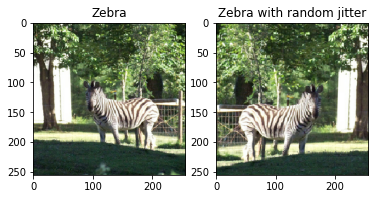

In [14]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

##3. Pix2Pix 모델 가져오기 및 재사용하기

설치된 tensorflow_examples 패키지를 통해 Pix2Pix에서 사용되는 생성기와 판별자를 가져온다  
이 튜토리얼에서 사용된 모델 아키텍처는 Pix2Pix에서 사용된 것과 매우 유사  
###Pix2Pix와 CycleGan의 차이점  
<ol><li>CycleGan은 배치정규화 대신 인스턴스 정규화 사용</li>
<li>논문에서는 수정된 resnet기반 생성기 이용, 여기서는 단순화를 위해 수정된 unet 생성기 이용</li>

2개의 생성기 및 2개의 판별자 훈련  
생성기 G는 이미지 X를 Y로 변환하는 방법 학습  
생성기 F는 이미지 Y를 X로 변환하는 방법 학습  
판별자 D_X는 이미지 X와 생성된 이미지 X를 구별하는 방법 학습  
판별자 D_Y는 이미지 Y와 생성된 이미지 Y를 구별하는 방법 학습  

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm', target=False)

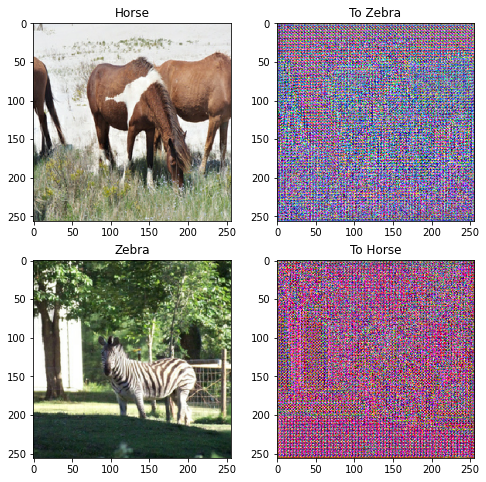

In [16]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

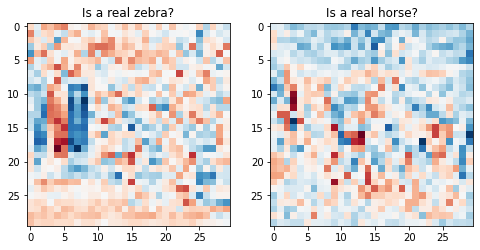

In [17]:
plt.figure(figsize = (8,8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

##4. 손실함수
CycleGan에는 훈련할 쌍으로 연결된 데이터가 없어 훈련 중에 입력 x와 대상 y의 쌍이 언제나 의미가 있다고 할 수 없음  
네트워크가 올바른 매핑을 학습하도록 강제하기 위해 **주기일관성손실** 제안  
판별자 손실 및 생성기 손실은 pix2pix에서 사용된 것과 유사

###주기일관성
결과가 원래 입력에 가까워야 함을 의미  
ex)문장을 영어에서 프랑스어로 번역한 다음 다시 프랑스어에서 영어로 번역하면 결과 문장과 원래 문장이 같아야함  
X-G생성기->Y->F생성기->X  
처음 x와 마지막 X사이에 평균절대오차가 계산됨

In [18]:
LAMBDA = 10

In [19]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #평균제곱오차

  return LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image)) #평균제곱오차
  return LAMBDA * 0.5 * loss

In [24]:
#모든 생성기 및 판별자의 옵티마이저 초기화
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [25]:
#체크포인트
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g, generator_f=generator_f, 
                           discriminator_x=discriminator_x, 
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer, 
                           generator_f_optimizer=generator_f_optimizer, 
                           discriminator_x_optimizer=discriminator_x_optimizer, 
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#if a checkpoint exists, restore the latst checkpoint
if ckpt_manager.latest_checkpoint:
  ckptrestore(ckpt_manager.latest_checkpoint)
  print('latest checkpoint restored!!')

##5. 훈련하기
훈련시간을 줄이기 위해 40epoch를 대상으로 훈련
-> 예측 정확성 떨어질 수 있음

In [26]:
EPOCHS = 40

In [27]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize = (12,12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title[i])
    #getting the pixel values between [0, 1] to plot it
    plt.imshow(display_list[i]*0.5 + 0.5)
    plt.axis('off')
  plt.show()

훈련루프 네가지 기본 단계
<ol><li>예측</li>
<li>손실을 계산</li>
<li>역전파를 사용하여 그래디언트를 계산</li>
<li>그래디언트를 옵티마이저에 적용</li></ol>

In [28]:
@tf.function
def train_step(real_x, real_y):
  #persistent is set to True because the tape is used more than once to calculate the gradients
  with tf.GradientTape(persistent=True) as tape:
    #Generator G translates X -> Y
    #Generator F translates Y -> X

    fake_y = generator_g(real_x, training = True)
    cycled_x = generator_f(fake_y, training = True)

    fake_x = generator_f(real_y, training = True)
    cycled_y = generator_g(fake_x, training = True)

    #same_x and same_y are used for identity loss
    same_x = generator_f(real_x, training = True)
    same_y = generator_g(real_y, training = True)

    disc_real_x = discriminator_x(real_x, training = True)
    disc_real_y = discriminator_y(real_y, training = True)

    disc_fake_x = discriminator_x(fake_x, training = True)
    disc_fake_y = discriminator_y(fake_y, training = True)

    #calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    #Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  #Calculate the gradients for generator and discriiminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  #Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

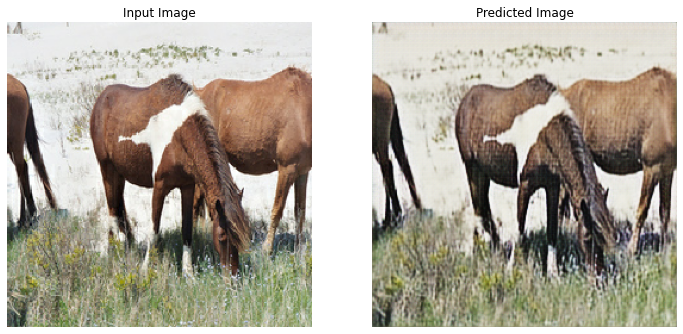

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end = ' ')
    n+=1

  clear_output(wait=True)
  #Using a consistent image(sample_horse) so that the progress of the model is clearly visible
  generate_images(generator_g, sample_horse)

  if(epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, time.time()-start))

In [ ]:
#Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)